# 코호트분석(Cohort Analysis)
- **특정 기간 동안 일정한 기준으로 동일하게 묶을 수 있는 사용자들의 집단을 분석하는 기법**이다.
- 가장 흔하게 쓰이는 방법은 특정 날짜를 기준으로 사용자들을 하나의 집단으로 묶어 이들의 행동을 분석하는 것이다.

## 코호트 분석을 하는 이유?
- 왜 고객들을 하나의 집단으로 묶는가?
- 고객들의 `Exit Rate`와 `Retention Rate`(재방문율 혹은 재구매율)을 파악하여 정기적으로 문제를 진단하고, 해결 전략을 도출하기 위한 대시보드로 많이 활용된다.
- 고객집단 별로 `고객 생애 가치(LTV, Lifetime Value)`를 계산하고, `서비스의 고착도(Stickiness)`를 판단할 수 있는 아주 중요한 수단이 된다.


## 데이터 준비

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_excel('https://github.com/springcoil/marsmodelling/blob/master/relay-foods.xlsx?raw=true', 
                 sheet_name='Purchase Data - Full Study')
df.head()

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09


- 모든 컬럼에 결측치가 존재하지 않는다.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   OrderId       2891 non-null   int64         
 1   OrderDate     2891 non-null   datetime64[ns]
 2   UserId        2891 non-null   int64         
 3   TotalCharges  2891 non-null   float64       
 4   CommonId      2891 non-null   object        
 5   PupId         2891 non-null   int64         
 6   PickupDate    2891 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(3), object(1)
memory usage: 158.2+ KB


## 데이터 전처리

- 'CommonId', 'PupId', 'PickupDate', 'TotalCharges' 컬럼은 삭제한다.

In [ ]:
df = df.drop(['CommonId', 'PupId', 'PickupDate', 'TotalCharges'], axis=1).copy()
df.head()

,OrderId,OrderDate,UserId
0,262,2009-01-11,47
1,278,2009-01-20,47
2,294,2009-02-03,47
3,301,2009-02-06,47
4,302,2009-02-06,47


- OrderDate칼럼의 데이터는 일단위로 구성되어 있으므로, 이 칼럼의 데이터를 사용하여 월단위 데이터를 추출할 수 있다.
- Order Date 컬럼이 Datetime (시계열) 데이터로 되어 있다.

In [ ]:
df['OrderDate']

0      2009-01-11
1      2009-01-20
2      2009-02-03
3      2009-02-06
4      2009-02-06
          ...    
2886   2010-03-08
2887   2010-03-07
2888   2010-03-07
2889   2010-03-08
2890   2010-03-08
Name: OrderDate, Length: 2891, dtype: datetime64[ns]

In [ ]:
df['OrderPeriod'] = df['OrderDate'].dt.strftime('%Y-%m')
df.head()

,OrderId,OrderDate,UserId,OrderPeriod
0,262,2009-01-11,47,2009-01
1,278,2009-01-20,47,2009-01
2,294,2009-02-03,47,2009-02
3,301,2009-02-06,47,2009-02
4,302,2009-02-06,47,2009-02


- **동일한 경험**이란 **첫 번째 주문이다**
- 고객 ID별 첫 번째 주문일자를 추가한다.

In [ ]:
# UserId 컬럼을 index로 설정한다.
df = df.set_index('UserId').copy()
df.head()

,OrderId,OrderDate,OrderPeriod
UserId,,,
47,262,2009-01-11,2009-01
47,278,2009-01-20,2009-01
47,294,2009-02-03,2009-02
47,301,2009-02-06,2009-02
47,302,2009-02-06,2009-02


- UserId 별 첫 주문일자의 년, 월까지만 나타낸다.

In [ ]:
df['FirstOrder'] = df.groupby(df.index)['OrderDate'].min().dt.strftime('%Y-%m')
df = df.reset_index()
df.head()

,UserId,OrderId,OrderDate,OrderPeriod,FirstOrder
0,47,262,2009-01-11,2009-01,2009-01
1,47,278,2009-01-20,2009-01,2009-01
2,47,294,2009-02-03,2009-02,2009-01
3,47,301,2009-02-06,2009-02,2009-01
4,47,302,2009-02-06,2009-02,2009-01


## 데이터 집계

- 고객들이 우리의 홈페이지를 처음 방문한 후, 자신의 니즈에 따라 계속적으로 이용할 수도 있고, 이용하지 않을 수도 있습니다. 이러한 활동을 월단위로 구분지어 본다면 아래의 표와 같을 것이다. (월별 방문자 수)

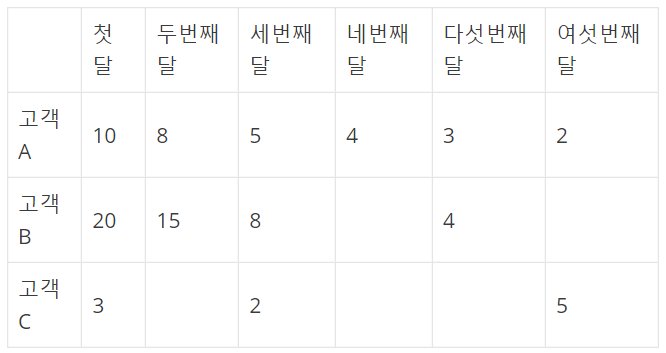

- 사용자 유지율을 파악하기 위한 코호트 분석에서는 위의 표처럼 각각의 방문을 모두 집계하는 것이 아니라 아래의 표처럼 `순방문자(UV)`로 집계해야 한다. (월별 순방문자 수)

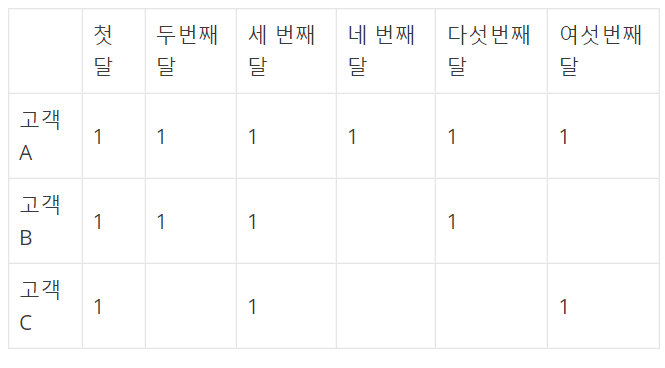

- 첫 주문일자를 나타내는 FirstOrder와 주문별 기간을 나타내는 OrderPeriod를 기준으로 그룹화 한다.
- 고객의 아이디 UserId를 집계하여 nunique를 통해 고유한 개수(순방문자 수)를 세어준다.
    - 한 고객이 여러 번 방문하더라도 한 번만 집계된다.

In [ ]:
cohorts = df.groupby(['FirstOrder', 'OrderPeriod'])['UserId'].nunique()
cohorts

FirstOrder  OrderPeriod
2009-01     2009-01         22
            2009-02          8
            2009-03         10
            2009-04          9
            2009-05         10
                          ... 
2010-01     2010-02         50
            2010-03         26
2010-02     2010-02        100
            2010-03         19
2010-03     2010-03         24
Name: UserId, Length: 119, dtype: int64

In [ ]:
cohorts = cohorts.reset_index()
cohorts.head()

,FirstOrder,OrderPeriod,UserId
0,2009-01,2009-01,22
1,2009-01,2009-02,8
2,2009-01,2009-03,10
3,2009-01,2009-04,9
4,2009-01,2009-05,10


- UserId 컬럼명으로 순방문자 수가 값으로 지정되어 있으므로 컬럼명을 변경해준다.

In [ ]:
cohorts = cohorts.rename(columns={'UserId':'TotalUsers'})
cohorts.head()

,FirstOrder,OrderPeriod,TotalUsers
0,2009-01,2009-01,22
1,2009-01,2009-02,8
2,2009-01,2009-03,10
3,2009-01,2009-04,9
4,2009-01,2009-05,10


- 데이터가 없는 기간을 체크한다.
- 고객이 언제 구매하였던 간에 처음 들어온 기간은 0, 두 번째 기간은 1, 세 번째 기간은 2, 네 번째 기간은 3으로 표기한다.

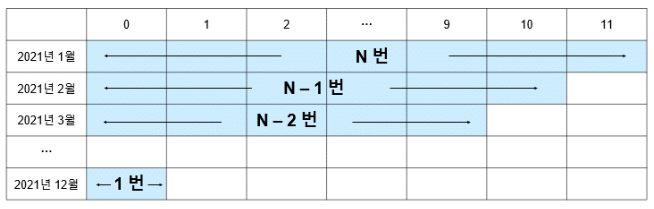

- 첫 번째 코호트 기간은 15번으로 구성되어 있기 때문에 두 번째 코호트 기간은 15-1= 14여야 하는데 13인것을 확인할 수 있다. 그 외의 데이터를 살펴보면 13,12,11,10... 등 정상적으로 처리되어 있는 것을 확인할 수 있다. 

In [ ]:
each_period = cohorts['FirstOrder'].value_counts().sort_index()
each_period

2009-01    15
2009-02    13
2009-03    13
2009-04    12
2009-05    11
2009-06    10
2009-07     9
2009-08     8
2009-09     7
2009-10     6
2009-11     5
2009-12     4
2010-01     3
2010-02     2
2010-03     1
Name: FirstOrder, dtype: int64

- 첫 방문일자가 '2009-02'인 데이터를 좀 더 구체적으로 확인해보면, '2010-03'인 데이터가 존재하지 않음을 확인할 수 있다.

In [ ]:
cohorts[cohorts['FirstOrder'] == '2009-02']

,FirstOrder,OrderPeriod,TotalUsers
15,2009-02,2009-02,15
16,2009-02,2009-03,3
17,2009-02,2009-04,5
18,2009-02,2009-05,1
19,2009-02,2009-06,4
20,2009-02,2009-07,4
21,2009-02,2009-08,4
22,2009-02,2009-09,5
23,2009-02,2009-10,5
24,2009-02,2009-11,4


- 데이터가 없는 기간도 포함하여 코호트 분석을 진행하기 위해 '2010-03'인 데이터를 추가시켜준다.

In [ ]:
cohorts.loc[cohorts.shape[0], 'FirstOrder'] = '2009-02'
cohorts.loc[cohorts.shape[0]-1, 'OrderPeriod'] = '2010-03'
cohorts.loc[cohorts.shape[0]-1, 'TotalUsers'] = 0

In [ ]:
cohorts = cohorts.sort_values(['FirstOrder', 'OrderPeriod'])

- '2010-03' 데이터가 제대로 입력되었다.

In [ ]:
cohorts[cohorts['FirstOrder'] == '2009-02']

,FirstOrder,OrderPeriod,TotalUsers
15,2009-02,2009-02,15.0
16,2009-02,2009-03,3.0
17,2009-02,2009-04,5.0
18,2009-02,2009-05,1.0
19,2009-02,2009-06,4.0
20,2009-02,2009-07,4.0
21,2009-02,2009-08,4.0
22,2009-02,2009-09,5.0
23,2009-02,2009-10,5.0
24,2009-02,2009-11,4.0


- 기간이 15부터 1까지 정상적으로 되어있다.

In [ ]:
each_period = cohorts['FirstOrder'].value_counts().sort_index()
each_period

2009-01    15
2009-02    14
2009-03    13
2009-04    12
2009-05    11
2009-06    10
2009-07     9
2009-08     8
2009-09     7
2009-10     6
2009-11     5
2009-12     4
2010-01     3
2010-02     2
2010-03     1
Name: FirstOrder, dtype: int64

- 기간별 레이블 붙이기
- 코호트 분석에서 처음 들어온 기간은 0, 두 번째 기간은 1, 세 번째 기간은 2, 네 번째 기간은 3으로 표기한다.
- ex) 2009-01은 15기간이므로 0 ~ 14까지 기간이 표기되어야 한다.

In [ ]:
cohortperiod = []

for x in each_period:
    for y in range(x):
        cohortperiod.append(y)

In [ ]:
cohorts['CohortPeriod'] = cohortperiod
cohorts.head(20)

,FirstOrder,OrderPeriod,TotalUsers,CohortPeriod
0,2009-01,2009-01,22.0,0
1,2009-01,2009-02,8.0,1
2,2009-01,2009-03,10.0,2
3,2009-01,2009-04,9.0,3
4,2009-01,2009-05,10.0,4
5,2009-01,2009-06,8.0,5
6,2009-01,2009-07,8.0,6
7,2009-01,2009-08,7.0,7
8,2009-01,2009-09,7.0,8
9,2009-01,2009-10,7.0,9


- `FirstOrder(동일한 경험)`과 `CohortPeriod(동일한 기간)`으로 인덱스를 만든다.

In [ ]:
cohorts = cohorts.set_index(['FirstOrder', 'CohortPeriod'])
cohorts

OrderPeriod  TotalUsers
FirstOrder CohortPeriod                        
2009-01    0                2009-01        22.0
           1                2009-02         8.0
           2                2009-03        10.0
           3                2009-04         9.0
           4                2009-05        10.0
...                             ...         ...
2010-01    1                2010-02        50.0
           2                2010-03        26.0
2010-02    0                2010-02       100.0
           1                2010-03        19.0
2010-03    0                2010-03        24.0

[120 rows x 2 columns]

In [ ]:
cohorts['TotalUsers']

FirstOrder  CohortPeriod
2009-01     0                22.0
            1                 8.0
            2                10.0
            3                 9.0
            4                10.0
                            ...  
2010-01     1                50.0
            2                26.0
2010-02     0               100.0
            1                19.0
2010-03     0                24.0
Name: TotalUsers, Length: 120, dtype: float64

- ustack(1)을 하게 되면 멀티 인덱스 [FirstOrder, CohortPeriod] 중에서 CohortPeriod가 컬럼으로 가게 된다.

In [ ]:
cohorts = cohorts['TotalUsers'].unstack(1)
cohorts

CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
FirstOrder,,,,,,,,,,,,,,,
2009-01,22.0,8.0,10.0,9.0,10.0,8.0,8.0,7.0,7.0,7.0,7.0,8.0,11.0,7.0,6.0
2009-02,15.0,3.0,5.0,1.0,4.0,4.0,4.0,5.0,5.0,4.0,3.0,3.0,5.0,0.0,NaN
2009-03,13.0,4.0,5.0,4.0,1.0,2.0,2.0,3.0,2.0,1.0,3.0,2.0,1.0,NaN,NaN
2009-04,39.0,13.0,10.0,13.0,6.0,7.0,4.0,6.0,2.0,4.0,3.0,2.0,NaN,NaN,NaN
2009-05,50.0,13.0,12.0,5.0,4.0,6.0,3.0,5.0,5.0,4.0,3.0,NaN,NaN,NaN,NaN
2009-06,32.0,15.0,9.0,6.0,7.0,5.0,3.0,3.0,10.0,3.0,NaN,NaN,NaN,NaN,NaN
2009-07,50.0,23.0,13.0,10.0,11.0,10.0,11.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
2009-08,31.0,11.0,9.0,7.0,6.0,8.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09,37.0,15.0,14.0,8.0,13.0,9.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 유지율 계산

- 코호트별 사용자 유지율 구하기
- `비율`의 의미에 대해 생각해보면, 처음의 순방문자 수에 비해 각 기간의 순방문자수가 얼마나 변화하였는지에 대한 것이다.
- 비율을 구하려면 전체 데이터를 첫 코호트 기간의 순방문자로 나누어주면 된다.

In [ ]:
# 첫 번째 컬럼은 각 코호트의 첫 번째 기간(0주)에 대한 데이터이다.
cohorts[0]

FirstOrder
2009-01     22.0
2009-02     15.0
2009-03     13.0
2009-04     39.0
2009-05     50.0
2009-06     32.0
2009-07     50.0
2009-08     31.0
2009-09     37.0
2009-10     54.0
2009-11    130.0
2009-12     65.0
2010-01     95.0
2010-02    100.0
2010-03     24.0
Name: 0, dtype: float64

- `전체 데이터(cohorts)`를 `첫 코호트 기간의 순방문자(cohorts[0])`로 `나누어(divide)` 주면 된다.
- `divide` 함수에 `axis=0`를 명시해야 전체 데이터를 첫 코호트 기간의 데이터로 나눌 수 있다.

In [ ]:
user_retention = cohorts.divide(cohorts[0], axis=0)
user_retention

CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
FirstOrder,,,,,,,,,,,,,,,
2009-01,1.0,0.363636,0.454545,0.409091,0.454545,0.363636,0.363636,0.318182,0.318182,0.318182,0.318182,0.363636,0.500000,0.318182,0.272727
2009-02,1.0,0.200000,0.333333,0.066667,0.266667,0.266667,0.266667,0.333333,0.333333,0.266667,0.200000,0.200000,0.333333,0.000000,NaN
2009-03,1.0,0.307692,0.384615,0.307692,0.076923,0.153846,0.153846,0.230769,0.153846,0.076923,0.230769,0.153846,0.076923,NaN,NaN
2009-04,1.0,0.333333,0.256410,0.333333,0.153846,0.179487,0.102564,0.153846,0.051282,0.102564,0.076923,0.051282,NaN,NaN,NaN
2009-05,1.0,0.260000,0.240000,0.100000,0.080000,0.120000,0.060000,0.100000,0.100000,0.080000,0.060000,NaN,NaN,NaN,NaN
2009-06,1.0,0.468750,0.281250,0.187500,0.218750,0.156250,0.093750,0.093750,0.312500,0.093750,NaN,NaN,NaN,NaN,NaN
2009-07,1.0,0.460000,0.260000,0.200000,0.220000,0.200000,0.220000,0.140000,0.140000,NaN,NaN,NaN,NaN,NaN,NaN
2009-08,1.0,0.354839,0.290323,0.225806,0.193548,0.258065,0.129032,0.129032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09,1.0,0.405405,0.378378,0.216216,0.351351,0.243243,0.216216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 시각화

- 코호트 시각화

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

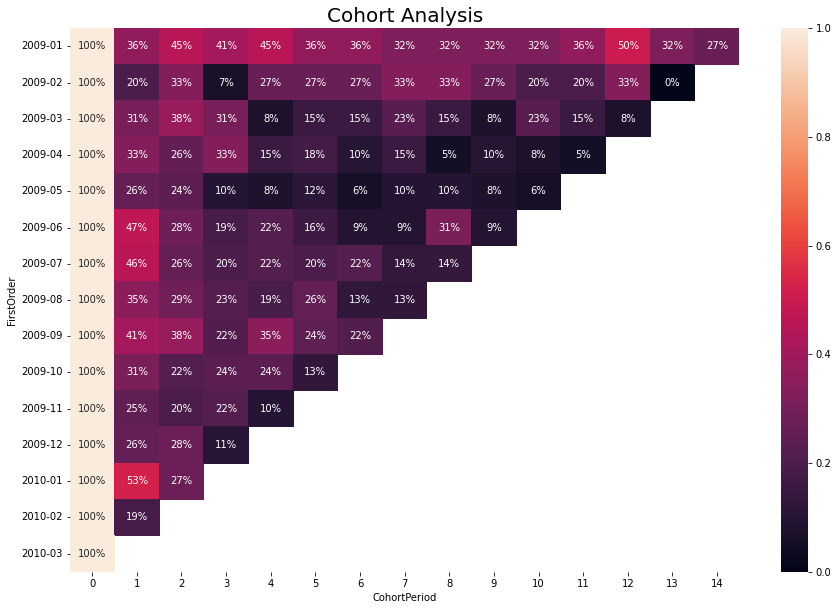

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('Cohort Analysis', fontsize=20)
sns.heatmap(user_retention, annot=True, fmt='.0%')
plt.show()

## 해석
### 목표1. 월별 소비자 집단 중 이탈이 가장 많은 집단 파악
- 코호트 기간을 1로 고정해 놓고 봤을 때 가장 이탈률이 높은 집단 순위를 산출해보겠다.
    - 2010년 2월 - 재구매율 19%
    - 2009년 2월 - 재구매율 20%
    - 2009년 11월 - 재구매율 25%
    - 2009년 5월 - 재구매율 26%
    - 2009년 12월 - 재구매율 26%

### 목표2. 수익성 기반 Retention을 재고해야 할 집단 선정
- 2010년 1월 - 약 9천 달러
- 2010년 2월 - 약 7천 달러
- 2009년 11월 - 약 6천 7백 달러